## [High-dimensional Bayesian workflow, with applications to SARS-CoV-2 strains](http://pyro.ai/examples/workflow.html#High-dimensional-Bayesian-workflow,-with-applications-to-SARS-CoV-2-strains)

#### The fastest way to find a good model of your data is to quickly discard many bad models, i.e. to iterate. In statistics we call this iterative workflow Box’s loop. 
#### An efficient workflow allows us to discard bad models as quickly as possible. Workflow efficiency demands that code changes to upstream components don’t break previous coding effort on downstream components. 
#### Pyro’s approaches to this challenge include strategies for variational approximations (pyro.infer.autoguide) and strategies for transforming model coordinate systems to improve geometry (pyro.infer.reparam

1. Clean the data.

2. Create a generative model.

3. Sanity check using MAP or mean-field inference.

4. Create an initialization heuristic.

5. Reparameterize the model, evaluating results under mean field VI.

6. Customize the variational family (autoguides, easyguides, custom guides).

##### The model is a high-dimensional regression model with around 1000 coefficients, a multivariate logistic growth function (using a simple torch.softmax()) and a Multinomial likelihood. While the number of coefficients is relatively small, there are about 500,000 local latent variables to estimate, and plate structure in the model should lead to an approximately block diagonal posterior covariance matrix

In [ ]:
from collections import defaultdict
from pprint import pprint
import functools
import math
import os

In [ ]:
import torch
import pyro

In [ ]:
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.distributions import constraints
from pyro.infer import SVI, Trace_ELBO

In [ ]:
from pyro.infer.autoguide import (
    AutoDelta,
    AutoNormal,
    AutoMultivariateNormal,
    AutoLowRankMultivariateNormal,
    AutoGuideList,
    init_to_feasible
)

In [ ]:
from pyro.infer.reparam import AutoReparam, LocScaleReparam

In [ ]:
from pyro.nn.module import PyroParam

In [ ]:
from pyro.optim import ClippedAdam

In [ ]:
from pyro.ops.special import sparse_multinomial_likelihood

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
if torch.cuda.is_available():
    torch.set_default_tensor_type("torch.cuda.FloatTensor")
else:
    pass

___

In [ ]:
from pyro.contrib.examples.nextstrain import load_nextstrain_counts

In [ ]:
data_set = load_nextstrain_counts()

In [ ]:
isinstance(data_set, dict)

In [ ]:
for k, v in data_set.items():
    print(k, type(v))

In [ ]:
isinstance(data_set, torch.Tensor)

#### The first step to using Pyro is creating a generative model, either a python function or a pyro.nn.Module. Start simple. Start with a shallow hierarchy and later add latent variables to share statistical strength. Start with a slice of your data then add a plate over multiple slices. Start with simple distributions like Normal, LogNormal, Poisson and Multinomial, then consider overdispersed versions like StudentT, Gamma, GammaPoisson/NegativeBinomial, and DirichletMultinomial. Keep your model simple and readable so you can share it and get feedback from domain experts. Use weakly informative priors.

#### Note we scale coef by 1/100 because we want to model a very small number, but the automatic parts of Pyro and PyTorch work best for numbers on the **order of 1.0 rather than very small numbers**. When we later interpret coef in a volcano plot we’ll need to duplicate this scaling factor.

In [ ]:
data_set.keys()

In [ ]:
data_set['counts'].numel()

In [ ]:
data_set['counts'].count_nonzero()

In [ ]:
data_set['time_step_days']

In [ ]:
data_set['features'].shape

In [ ]:
data_set['counts'].shape

In [ ]:
def model(data_set):
    features = data_set['features']
    counts = data_set['counts']

    assert features.shape[0] == counts.shape[-1]
    S, M = features.shape # 1316, 2634 mutations
    T, P, S = counts.shape # 27 time, 202 places, 1326 clusters/strain

    time = torch.arange(float(T)) * data_set['time_step_days'] / 5.5
    time -= time.mean()

    strain_plate = pyro.plate("strain", S, dim = -1)
    place_plate = pyro.plate("place", P, dim= -2)
    time_plate = pyro.plate("time", T, dim = -3)

    rate_scale = pyro.sample("rate_scale", dist.LogNormal(-4,2))
    init_sacle = pyro.sample('init_scale', dist.LogNormal(0, 2))

    with pyro.plate("mutation", M, dim = -1):
        coef = pyro.sample('coef', dist.Laplace(0,0.5))

    with strain_plate:
        rate_loc = pyro.deterministic("rate_loc", 0.01 * coef @ features.T) 
    
    with place_plate, strain_plate:
        rate = pyro.sample("rate", dist.Normal(rate_loc, rate_scale))
        init = pyro.sample("init", dist.Normal(0, init_sacle))

    logits = init + rate * time[:, None, None]

    with time_plate, place_plate:
        pyro.sample(
            "obs",
            dist.Multinomial(logits=logits.unsqueeze(-2), validate_args=False),
            obs = counts.unsqueeze(-2),
        )

In [46]:
def fit_svi(model, guide, lr=0.01, num_steps = 1001, log_every = 100, plot=True):
    pyro.clear_param_store()
    pyro.set_rng_seed(20221114)

    num_latents = sum(
        site['value'].numel()
        for name, site in poutine.trace(guide).get_trace(data_set).iter_stochastic_nodes()
        if not site['infer'].get("is_auxiliary")
    )

    num_params = sum(
        p.unconstrained().numel() for p in pyro.get_param_store().values()
    )

    print(f"found {num_latents} latent variables and {num_params} learnable parameters")

    series =  defaultdict(list)
    def hook(g, series):
        series.append(torch.linalg.norm(g.reshape(-1), math.inf).item())
    for name, value in pyro.get_param_store().named_parameters():
        value.register_hook(
            functools.partial(hook, series=series[name+" grad"])
        )
    
    optim = ClippedAdam({"lr": lr, "lrd": 0.1 ** (1/num_steps)})

    svi = SVI(model, guide, optim, Trace_ELBO())

    num_obs = int(data_set['counts'].count_nonzero())

    for step in range(num_steps):
        loss = svi.step(data_set) / num_obs
        series["loss"].append(loss)
        median = guide.median()
        for name, value in median.items():
            if value.numel() == 1:
                series[name+" mean"].append(float(value))
        if step % log_every == 0:
            print(f"step {step: >4d} loss= {loss:0.6g}")

    if plot:
        plt.figure(figsize=(18,12))
        for name, Y in series.items():
            if name == "loss":
                plt.plot(Y, "k--", label=name, zorder =0)
            elif name.endswith("mean"):
                plt.plot(Y, label=name, zorder=-1)
            else:
                plt.plot(Y, label=name, alpha=0.5, lw=1, zorder=-2)
        plt.yscale("log")
        plt.xscale("symlog")
        plt.xlim(0, None)
        plt.legend(loc="best", fontsize=8)
        plt.tight_layout()

found 538452 latent variables and 1068600 learnable parameters
step    0 loss= 267.617
step  100 loss= 63.3154
step  200 loss= 44.5881
step  300 loss= 34.7554
step  400 loss= 30.3903
step  500 loss= 27.5463
step  600 loss= 25.4311
step  700 loss= 23.8737
step  800 loss= 22.7743
step  900 loss= 21.8899
step 1000 loss= 21.2318
CPU times: user 13min 41s, sys: 3.6 s, total: 13min 45s
Wall time: 3min 35s


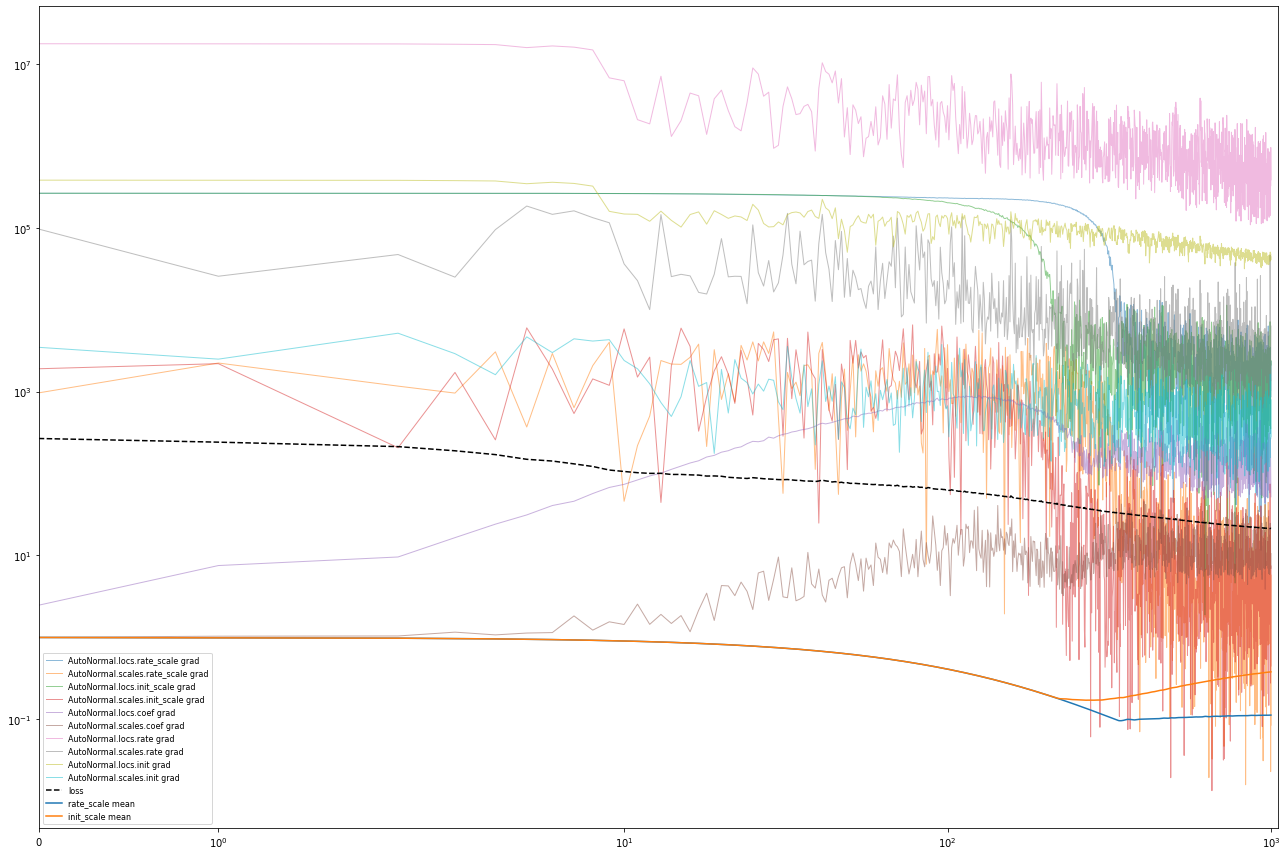

In [47]:
%%time
guide = AutoNormal(model, init_scale=0.01)
fit_svi(model, guide)